# Лабораторная работа №8: Кластеризация

### 1: Подготовка и импорт библиотек


#### Подключим необходимые библиотеки


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

try:
    from cuml.cluster import DBSCAN as cuML_DBSCAN
    GPU_AVAILABLE = True
    print("Будем использовать GPU")
except ImportError:
    print("Будем использовать CPU")
    from sklearn.cluster import DBSCAN as Sklearn_DBSCAN
    GPU_AVAILABLE = False

Будем использовать GPU


#### Загрузка данных


In [28]:
file_path = '/content/27_B_17834.csv'
try:
  df = pd.read_csv(file_path, header=0, decimal=',', sep=';')

except FileNotFoundError:
  print("Check file existance")

df.head()

,X,Y
0,7.084,7.959
1,-0.759,5.781
2,6.736,4.640
3,7.899,7.361
4,0.297,5.932


### 2: Кластеризация с помощью DBSCAN
Используем **DBSCAN** с радиусом **eps=1**, как и требовалось в задании. Этот параметр был подобран экспериментально, чтобы корректно разделить визуально обособленные группы точек.

In [24]:
params = {'eps': 1, 'min_samples': 5}

if GPU_AVAILABLE:
    print("Запускаем кластеризацию на GPU...")
    dbscan = cuML_DBSCAN(**params)
else:
    print("Запускаем кластеризацию на CPU...")
    dbscan = Sklearn_DBSCAN(**params)

clusters = dbscan.fit_predict(df[['X', 'Y']])
df['cluster'] = clusters

print("\nКластеризация завершена.")
print("Распределение звезд по кластерам:")
df['cluster'].value_counts()

Запускаем кластеризацию на GPU...

Кластеризация завершена.
Распределение звезд по кластерам:


,count
cluster,
1,3500
0,3200
2,3200


Вывод: Получилось три класстера примеро одинакового размера

### 3: Поиск центройдов
Определим для каждого кластера центроид.

In [25]:
centroids = []
unique_clusters = sorted(df['cluster'].unique())

print("\nНачинаем поиск центроидов...")

for cluster_id in unique_clusters:
    print(f"  Обработка кластера №{cluster_id}...")
    cluster_df = df[df['cluster'] == cluster_id]

    min_total_distance = float('inf')
    best_centroid = None

    points = cluster_df[['X', 'Y']].values

    for index, candidate_centroid in cluster_df.iterrows():
        candidate_point = candidate_centroid[['X', 'Y']].values
        current_total_distance = np.sqrt(np.sum((points - candidate_point)**2, axis=1)).sum()

        if current_total_distance < min_total_distance:
            min_total_distance = current_total_distance
            best_centroid = candidate_centroid

    centroids.append(best_centroid)

centroids_df = pd.DataFrame(centroids)
print("\nПоиск центроидов завершен.")


Начинаем поиск центроидов...
  Обработка кластера №0...
  Обработка кластера №1...
  Обработка кластера №2...

Поиск центроидов завершен.


## Результат
Выводим координаты найденных центроидов. И строим график.

--- ИТОГОВЫЙ ОТВЕТ ---
Координаты центроидов для каждого кластера:


,X,Y
9435,7.563,5.851
2585,0.549,5.016
3374,4.146,-0.294


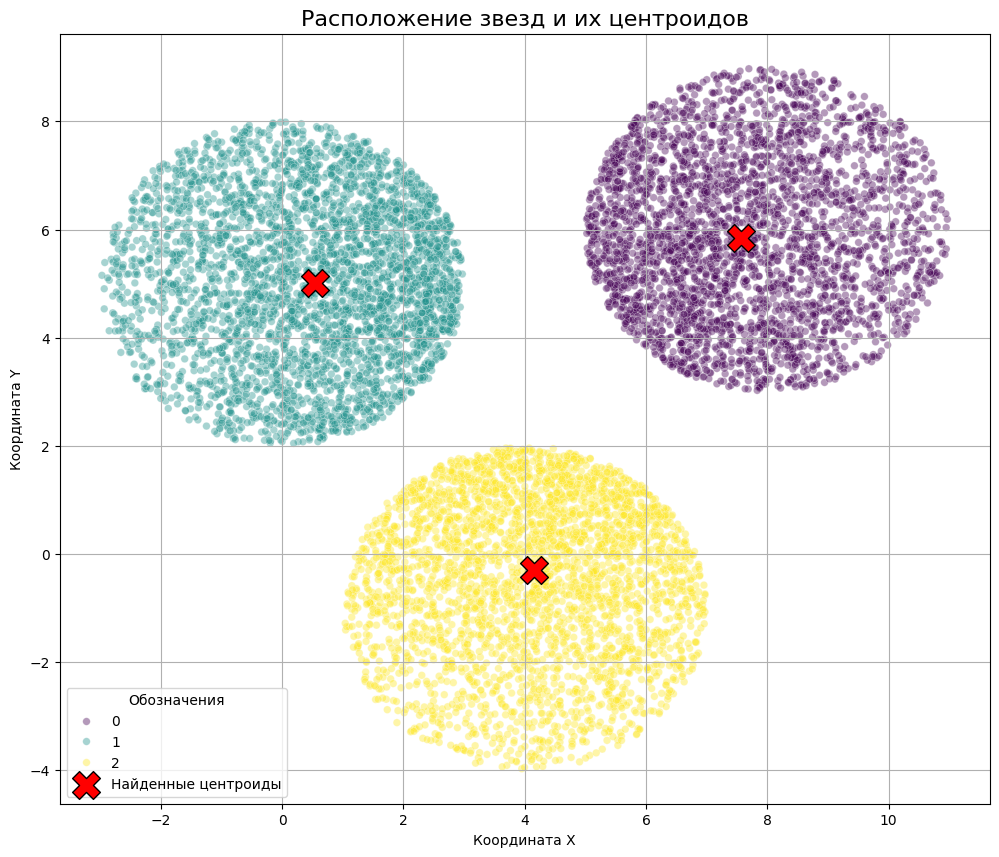

In [26]:
print("--- ИТОГОВЫЙ ОТВЕТ ---")
print("Координаты центроидов для каждого кластера:")
display(centroids_df[['X', 'Y']])

# Визуализация с центроидами
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='X', y='Y', hue='cluster', palette='viridis', s=30, alpha=0.4)
plt.scatter(centroids_df['X'], centroids_df['Y'],
            marker='X', s=400, c='red', edgecolor='black', zorder=5, label='Найденные центроиды')

plt.title('Расположение звезд и их центроидов', fontsize=16)
plt.xlabel('Координата X')
plt.ylabel('Координата Y')
plt.legend(title='Обозначения')
plt.grid(True)
plt.show()

Вывод: По граффику можно понять, что гиперпараметры подобранны правильно и кластеры хорошо заметны.